In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numba import njit
from sklearn.cluster import KMeans

In [2]:
%%time
N=1024
var_J=1

@njit
def initial_lattice(N):
    M=np.ones((N))
    l=np.array([1,-1])
    for i in range(N):
            M[i]=np.random.choice(l)
    return(M)

@njit
def intraction(N,mean_J,var_J):
    J_matrix=np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i<j :
                J_matrix[i][j]=random.gauss(mean_J/N,var_J/np.sqrt(N))
            else :
                J_matrix[i][j]=0
    J_matrix=J_matrix+np.transpose(J_matrix)  
    return(J_matrix)

@njit
def energy_local(M,J_matrix,i):
    H=np.sum(-J_matrix[i]*M[i]*M)
    return(H)

@njit
def energy_total(M,J_matrix,N):
    E_t=0
    for i in range(N):
        E_t=E_t+energy_local(M,J_matrix,i)
    E_t=E_t/2
    return(E_t)


@njit
def trial(J_matrix,N,T): 
    field_list=np.zeros(N)
    M=initial_lattice(N)
    E_t=energy_total(M,J_matrix,N)
    for trial in range(int(np.sqrt(N**3))):
        random_i=random.randrange(N)                
        M[random_i]=M[random_i]*(-1)
        delta_E=2*energy_local(M,J_matrix,random_i)
        if delta_E>0:
            p=np.exp(-delta_E/T)
            coin=random.random()
            if coin>p :
                M[random_i]=M[random_i]*(-1)
            else :
                E_t=E_t+delta_E
        else :
            E_t=E_t+delta_E
    
    for i in range(N):
        field=np.sum(-J_matrix[i]*M)
        field_list[i]=field

    return(field_list)

l_feature=[]
#Spin glass
l_feature=[]
for mean_J in np.arange(0.000001,0.010001,0.001):
    for T in np.arange(0.000001,0.010001,0.001):
        l=[]
        J_matrix=intraction(N,mean_J,var_J)
        field_time_series=trial(J_matrix,N,T)
        l.append(abs(np.mean(field_time_series)))
        l.append(np.var(field_time_series))
        l_feature.append(l)
        
#Paramagnetic       
for mean_J in np.arange(0.000001,0.010001,0.001):
    for T in np.arange(1000,1000.01,0.001):
        l=[]
        J_matrix=intraction(N,mean_J,var_J)
        field_time_series=trial(J_matrix,N,T)
        l.append(abs(np.mean(field_time_series)))
        l.append(np.var(field_time_series))
        l_feature.append(l)

#Ferromagnetic       
for mean_J in np.arange(1000,1000.01,0.001):
    for T in np.arange(0.000001,0.010001,0.001):
        l=[]
        J_matrix=intraction(N,mean_J,var_J)
        field_time_series=trial(J_matrix,N,T)
        l.append(abs(np.mean(field_time_series))/mean_J)
        l.append(np.var(field_time_series))
        l_feature.append(l)

X = np.array(l_feature)
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

Wall time: 35 s


In [3]:
%%time

def calculate_similarity(point, centroids):
    similarities = []
    for centroid in centroids:
        distance = np.linalg.norm(point - centroid)
        # Similarity as the inverse of distance
        similarity = 0.0001 / (0.0001 + distance)
        similarities.append(similarity)
    return similarities


point_list=[]
for mean_J in np.arange(0.000001,3,0.1):
    l=[] 
    for T in np.arange(0.000001,3,0.1):
        var_J=1
        mean_percentage_similarity=np.zeros((1,3))
        for i in range(20):
            J_matrix=intraction(N,mean_J,var_J)
            field_time_series=trial(J_matrix,N,T)
            if abs(np.mean(field_time_series))>1 :
                new_point = np.array([abs(np.mean(field_time_series))/mean_J, np.var(field_time_series)])  # New point
            else :
                new_point = np.array([abs(np.mean(field_time_series)), np.var(field_time_series)])  # New point

            # Similarity between the new point and each cluster centroid
            similarities = calculate_similarity(new_point, centroids)

            total_similarity = sum(similarities)
            percentage_similarity = [similarity / total_similarity for similarity in similarities]
            mean_percentage_similarity=mean_percentage_similarity+np.array(percentage_similarity)

        mean_percentage_similarity=(mean_percentage_similarity)/(20)
        l.append(mean_percentage_similarity[0])
    point_list.append(l)

Wall time: 42min 25s


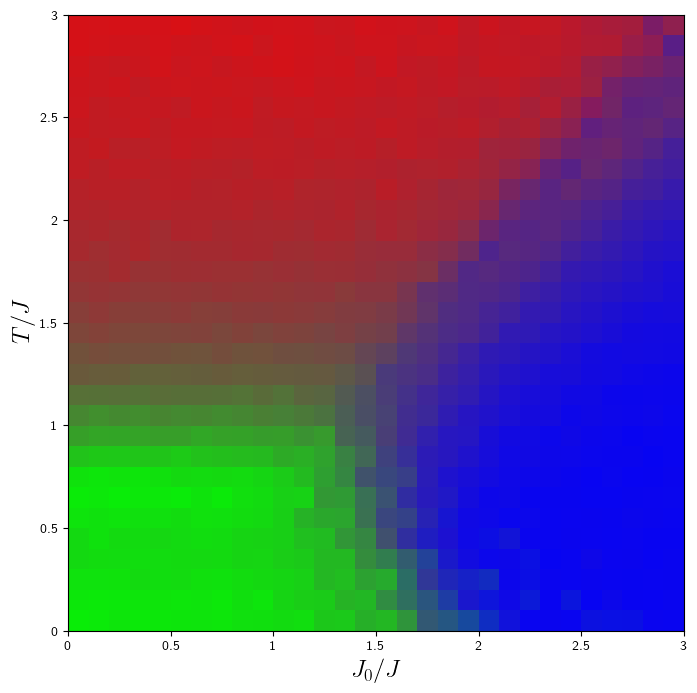

In [4]:
from scipy.ndimage import rotate
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(8,8))
rotated_array = rotate(point_list, 90, reshape=True)
plt.imshow(rotated_array)
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 30, 5))
ax.set_yticks(np.arange(-0.5, 30, 5))
ax.set_xticklabels([0,0.5,1,1.5,2,2.5,3])
ax.set_yticklabels([3,2.5,2,1.5,1,0.5,0])

ax.set_xlabel('\\textit{$J_0/J$}',fontsize=18)
ax.set_ylabel('\\textit{$T/J$}',fontsize=18)
plt.savefig("phase-diagram1.png")